In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mutual_info_score, accuracy_score, f1_score, log_loss
from IPython.display import display

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

import catboost

In [2]:
!ls

__pycache__
catboost_info
common_module.py
data_analysis.ipynb
model.bin
predict.py
predict_test.py
README.md
students_adaptability_level_online_education.csv
tempCodeRunnerFile.py
train.py


In [3]:
raw_df = pd.read_csv("students_adaptability_level_online_education.csv")

There are all columns of the data:

In [4]:
raw_df.columns.to_list()

['Gender',
 'Age',
 'Education Level',
 'Institution Type',
 'IT Student',
 'Location',
 'Load-shedding',
 'Financial Condition',
 'Internet Type',
 'Network Type',
 'Class Duration',
 'Self Lms',
 'Device',
 'Adaptivity Level']

# Data split

I will divide the data into 2 parts before exploratory data analysis (EDA): full_train and test. This will prevent data leaks.

In [5]:
raw_X = raw_df.drop("Adaptivity Level", axis=1)
raw_y = raw_df["Adaptivity Level"]

In [6]:
X_full_train, X_test, y_full_train, y_test = train_test_split(raw_X, raw_y, test_size=0.2, random_state=1)

X_full_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_full_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

Checking that they split up correctly:

In [7]:
X_full_train.shape[0], y_full_train.shape[0], X_test.shape[0], y_test.shape[0]

(964, 964, 241, 241)

In [8]:
X_full_train.shape[0] / (X_full_train.shape[0] + X_test.shape[0])

0.8

# Data preprocessing and preliminary analysis

Now I can look at some raws of the data.

In [9]:
X_full_train.head()

,Gender,Age,Education Level,Institution Type,IT Student,Location,Load-shedding,Financial Condition,Internet Type,Network Type,Class Duration,Self Lms,Device
0,Boy,16-20,College,Government,No,Yes,High,Mid,Wifi,4G,1-3,No,Mobile
1,Boy,11-15,School,Non Government,No,Yes,Low,Mid,Mobile Data,4G,1-3,No,Mobile
2,Boy,1-5,School,Non Government,No,Yes,Low,Mid,Wifi,4G,1-3,No,Mobile
3,Boy,16-20,College,Government,No,Yes,Low,Mid,Wifi,4G,1-3,No,Mobile
4,Girl,21-25,University,Non Government,Yes,Yes,High,Mid,Wifi,4G,1-3,No,Mobile


Lower the case of letters and replace spaces with underscores:

In [10]:
X_full_train.columns = X_full_train.columns.str.replace(" ", "_").str.lower()

The column names now look good. It can be done for values too. But first I will display if there is missing data:

In [11]:
X_full_train.isna().sum()

gender                 0
age                    0
education_level        0
institution_type       0
it_student             0
location               0
load-shedding          0
financial_condition    0
internet_type          0
network_type           0
class_duration         0
self_lms               0
device                 0
dtype: int64

I am lucky, there is 0 NaN values here.

In [12]:
X_full_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 964 entries, 0 to 963
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   gender               964 non-null    object
 1   age                  964 non-null    object
 2   education_level      964 non-null    object
 3   institution_type     964 non-null    object
 4   it_student           964 non-null    object
 5   location             964 non-null    object
 6   load-shedding        964 non-null    object
 7   financial_condition  964 non-null    object
 8   internet_type        964 non-null    object
 9   network_type         964 non-null    object
 10  class_duration       964 non-null    object
 11  self_lms             964 non-null    object
 12  device               964 non-null    object
dtypes: object(13)
memory usage: 98.0+ KB


Display unique values for each column:

In [13]:
cols = X_full_train.columns.tolist()

for c in cols:
    print(f"Column: {c}\nValues:", X_full_train[c].unique().tolist(), "\n")

Column: gender
Values: ['Boy', 'Girl'] 

Column: age
Values: ['16-20', '11-15', '1-5', '21-25', '6-10', '26-30'] 

Column: education_level
Values: ['College', 'School', 'University'] 

Column: institution_type
Values: ['Government', 'Non Government'] 

Column: it_student
Values: ['No', 'Yes'] 

Column: location
Values: ['Yes', 'No'] 

Column: load-shedding
Values: ['High', 'Low'] 

Column: financial_condition
Values: ['Mid', 'Rich', 'Poor'] 

Column: internet_type
Values: ['Wifi', 'Mobile Data'] 

Column: network_type
Values: ['4G', '3G', '2G'] 

Column: class_duration
Values: ['1-3', '3-6', '0'] 

Column: self_lms
Values: ['No', 'Yes'] 

Column: device
Values: ['Mobile', 'Computer', 'Tab'] 



And unique values of the target variable, "Adaptivity level":

In [14]:
y_full_train.unique().tolist()

['Moderate', 'Low', 'High']

Nothing suspicious.

In [15]:
cols_str = cols.copy()
cols_str.remove("age")
cols_str.remove("class_duration")

X_full_train[cols_str] = X_full_train[cols_str].apply(lambda x : x.str.lower().str.replace(' ','_'))

In [16]:
X_full_train.head(3)

,gender,age,education_level,institution_type,it_student,location,load-shedding,financial_condition,internet_type,network_type,class_duration,self_lms,device
0,boy,16-20,college,government,no,yes,high,mid,wifi,4g,1-3,no,mobile
1,boy,11-15,school,non_government,no,yes,low,mid,mobile_data,4g,1-3,no,mobile
2,boy,1-5,school,non_government,no,yes,low,mid,wifi,4g,1-3,no,mobile


Colulmns "institution_type", "it_student", "location", "self_lms" are binary. I will replace them by 1 and 0:

In [17]:
X_full_train.institution_type = X_full_train.institution_type.replace({"government": 1, "non_government": 0})
X_full_train.it_student = X_full_train.it_student.replace({"yes": 1, "no": 0})
X_full_train.location = X_full_train.location.replace({"yes": 1, "no": 0})
X_full_train.self_lms = X_full_train.self_lms.replace({"yes": 1, "no": 0})

All other columns are classes. It is better to use One Hot Encoding for their processing.

# Exploratory data analysis

Show classes distribution:

In [18]:
sns.set(font_scale=1.5)

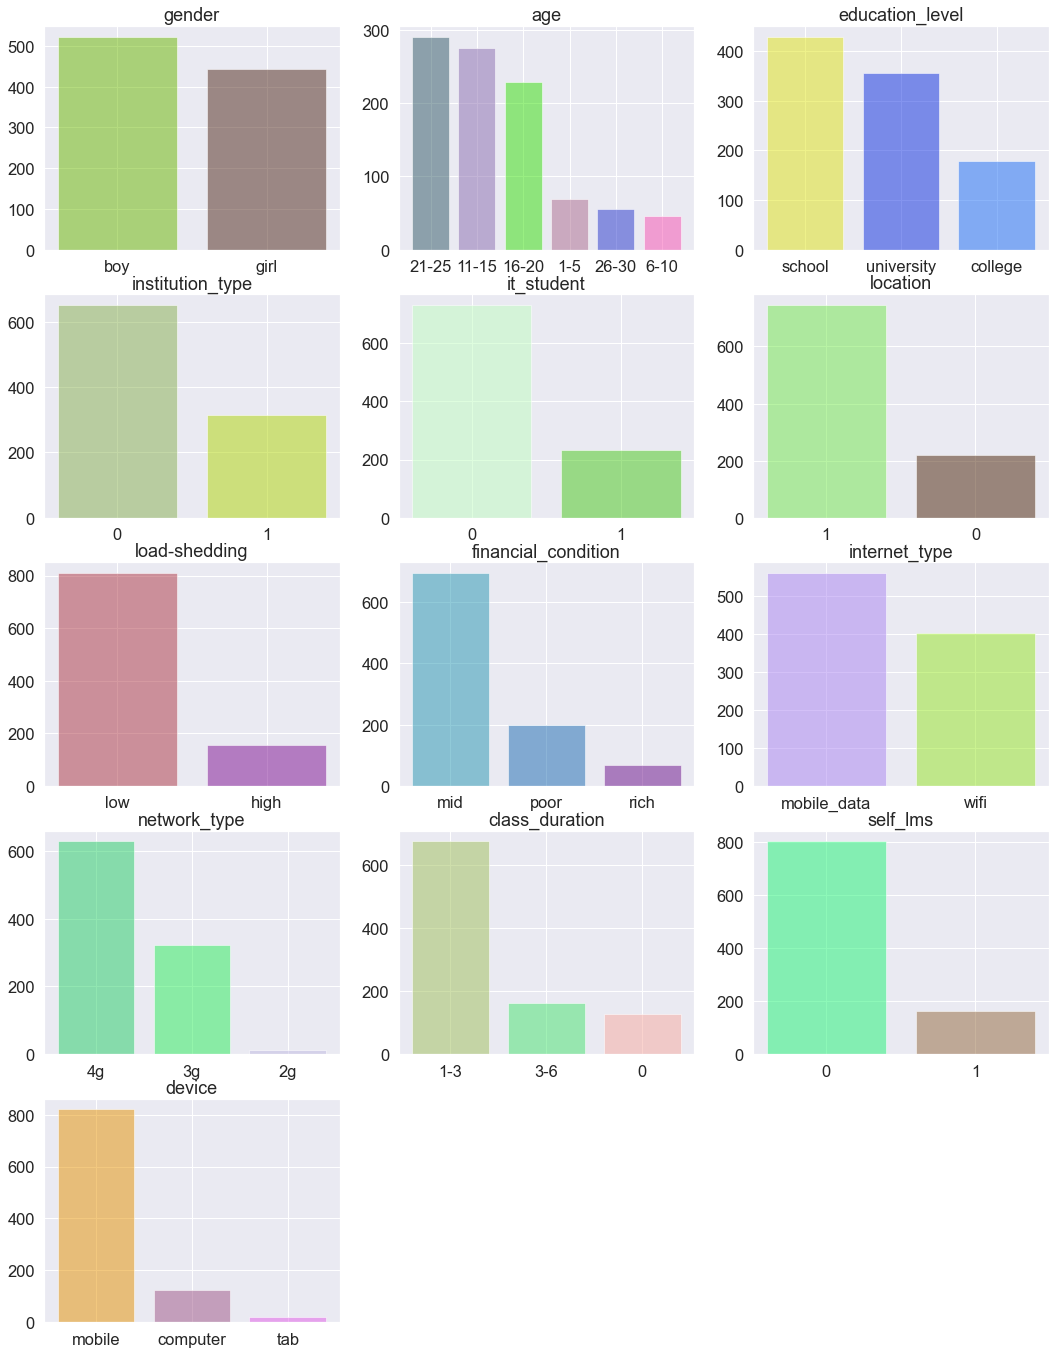

In [19]:
np.random.seed(1)

fig, ax = plt.subplots(5, 3, figsize=(18,18))
plt.subplots_adjust(bottom=11, top=12)

x_sub = 0

for col in cols:
    values = X_full_train[col].astype("str").value_counts()
    names = values.axes[0].tolist()
    
    colors = [np.random.rand(3,) for _ in X_full_train[col].unique()]
    ax.flatten()[x_sub].bar(names, values, color=colors, alpha=0.5)
    ax.flatten()[x_sub].set_title(col)
    
    x_sub += 1

ax.flatten()[-1].set_visible(False)
ax.flatten()[-2].set_visible(False)

According to the graphs, it can be concluded that not all features have a uniform distribution:
- Columns "network_type" and "device" have one class each, the valuse of which are very few;
- The average age of the respondents is from 11 to 25. But the number of those students whose age is from 26 to 30 is comparable to the number of children under 10 years old.

Gradient boosting models are able to work with uneven  data. I will try to use them. 

Display the number of values for all columns:

In [20]:
for col in cols:
    print(col, ":")
    col_df = pd.DataFrame(X_full_train[col].value_counts())
    col_df = col_df.rename(columns={col: 'count'})
    col_df['percentage'] = ((col_df / col_df.sum()) * 100).round(2)
    display(col_df)

gender :


,count,percentage
boy,522,54.15
girl,442,45.85


age :


,count,percentage
21-25,290,30.08
11-15,275,28.53
16-20,228,23.65
1-5,69,7.16
26-30,56,5.81
6-10,46,4.77


education_level :


,count,percentage
school,429,44.50
university,356,36.93
college,179,18.57


institution_type :


,count,percentage
0,651,67.53
1,313,32.47


it_student :


,count,percentage
0,730,75.73
1,234,24.27


location :


,count,percentage
1,745,77.28
0,219,22.72


load-shedding :


,count,percentage
low,809,83.92
high,155,16.08


financial_condition :


,count,percentage
mid,695,72.10
poor,199,20.64
rich,70,7.26


internet_type :


,count,percentage
mobile_data,561,58.2
wifi,403,41.8


network_type :


,count,percentage
4g,628,65.15
3g,323,33.51
2g,13,1.35


class_duration :


,count,percentage
1-3,676,70.12
3-6,162,16.80
0,126,13.07


self_lms :


,count,percentage
0,803,83.3
1,161,16.7


device :


,count,percentage
mobile,820,85.06
computer,124,12.86
tab,20,2.07


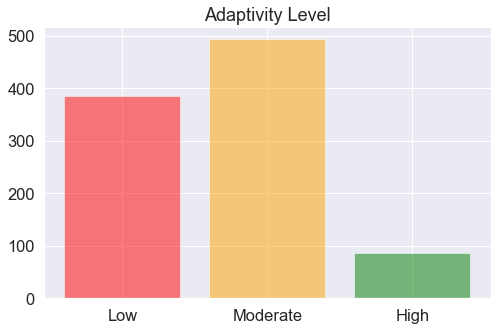

In [21]:
np.random.seed(5)

plt.figure(figsize=(8, 5))
values = y_full_train.value_counts()[["Low", "Moderate", "High"]]
names = values.axes[0].tolist()

colors = [np.random.rand(3,) for _ in names]

plt.bar(names, values, color=["red", "orange", "green"], alpha=0.5)
plt.title("Adaptivity Level")
None

The classes of the target variable have a good distribution

### Feature importance

To find out the importance of each characteristic, I will calculate the mutual info score with the target variable:

In [22]:
def mutual_info_adaptivity_level(series):
    return mutual_info_score(series, y_full_train)

In [23]:
mi = X_full_train.apply(mutual_info_adaptivity_level)
mi.sort_values(ascending=False)

class_duration         0.104240
age                    0.064535
financial_condition    0.057779
institution_type       0.052863
location               0.040857
education_level        0.026065
device                 0.020734
network_type           0.012031
internet_type          0.010946
self_lms               0.010629
gender                 0.007017
it_student             0.006279
load-shedding          0.005392
dtype: float64

# Model training

I will try several models to get the best result. Then I want to stack the models with the highest results into final one. To test the gradient boosting model, I will split X_full_train into training and validation data, and use cross validation to test the other models. This is because gradient boosting takes a long time to train.

First of all, I'm going to build a Pipeline for fast data processing. Then - to find the best hyperparameters using grid search.

#### Logistic regression

In [24]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse=False, handle_unknown="ignore", drop="first"), cols)
    ]
)

X_processed = preprocessor.fit_transform(X_full_train)

model = LogisticRegression(max_iter=1000)
model.fit(X_processed, y_full_train.to_numpy())


preds_full_train = model.predict(X_processed)

print("F1 score:", f1_score(y_full_train, preds_full_train, average='macro'))
print("Cross validation accuracy score:", cross_val_score(model, X_processed, y_full_train, cv=5).mean())

F1 score: 0.6762226724477829
Cross validation accuracy score: 0.700151122625216


In [25]:
def train_check_model(model, params, search="grid"):
    """encodes X_full_train with OneHotEncoder, search hyperparameters and prints F1 score and cross_val_score.
       model: your ML model;
       params: a dict with hyperparameters and their values;
       search: ["grid", "random"]
       """
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(sparse=False, handle_unknown="ignore", drop="first"), cols)
        ]
    )

    X_processed = preprocessor.fit_transform(X_full_train)

    if search == "grid":
        search = GridSearchCV(model, params, cv=5)
    elif search == "random":
        search = RandomizedSearchCV(model, params, n_iter=10, cv=5, n_jobs=-1, random_state=1)
    else:
        print("Error: invalid no search method")
        return
    
    search.fit(X_processed, y_full_train.to_numpy())
    
    print(search.best_estimator_, '\nBest score:', search.best_score_)
    
    preds_full_train = search.predict(X_processed)
    
    print("F1 score:", f1_score(y_full_train, preds_full_train, average='macro'))
    print("Cross validation accuracy score:", cross_val_score(search, X_processed, y_full_train, cv=5).mean())

In [26]:
logreg_model = LogisticRegression(max_iter=1000, n_jobs=-1, penalty="l2")
logreg_params = {"C": [100, 10, 2, 1, 0.1, 0.01, 0.001],
                 "solver": ["lbfgs", "newton-cg"]}

train_check_model(logreg_model, logreg_params)

LogisticRegression(C=1, max_iter=1000, n_jobs=-1) 
Best score: 0.700151122625216
F1 score: 0.6762226724477829
Cross validation accuracy score: 0.6908408894645942


It seems like tuning the hyperparameters does not improve the accuracy of the logistic regression model.

#### Random forest

For random forest, I will use RandomizedSearchCV

In [27]:
rf_model = RandomForestClassifier(random_state=1, n_jobs=-1)
rf_params = {"n_estimators": [10, 20, 50, 100, 150, 200],
             "criterion": ["gini", "entropy"],
             "max_depth": [2, 5, 10, 15, 20, 30],
             "min_samples_leaf": [1, 2, 3, 4, 5],
             "max_features": ["sqrt", 2, 5, 10]}

train_check_model(rf_model, rf_params, search="random")

RandomForestClassifier(criterion='entropy', max_depth=10, max_features='sqrt',
                       n_estimators=10, n_jobs=-1, random_state=1) 
Best score: 0.8786539291882557
F1 score: 0.9076829908555138
Cross validation accuracy score: 0.8786539291882557


I think that it is a good result.

#### Gradient Boosting

I chose CatBoost as my gradient boosting library. Its advantage is that it does not require pre-processing of categorical data.

In order to use it, I need to split the dataset:

In [28]:
X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, test_size=0.25, random_state=1)

X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

X_train.shape[0], y_train.shape[0], X_val.shape[0], y_val.shape[0]

(723, 723, 241, 241)

In [29]:
(X_train.shape[0] + X_val.shape[0]) / (X_full_train.shape[0] + X_test.shape[0])

0.8

In [30]:
boosting_model = catboost.CatBoostClassifier(n_estimators=200,
                                             cat_features=cols)

boosting_model.fit(X_train, y_train)

y_train_predicted = boosting_model.predict(X_train)
y_val_predicted = boosting_model.predict(X_val)

Learning rate set to 0.303228
0:	learn: 0.9635134	total: 180ms	remaining: 35.8s
1:	learn: 0.8868309	total: 211ms	remaining: 20.8s
2:	learn: 0.8402531	total: 236ms	remaining: 15.5s
3:	learn: 0.8120937	total: 268ms	remaining: 13.1s
4:	learn: 0.7886964	total: 305ms	remaining: 11.9s
5:	learn: 0.7644410	total: 341ms	remaining: 11s
6:	learn: 0.7457754	total: 375ms	remaining: 10.3s
7:	learn: 0.7346007	total: 410ms	remaining: 9.83s
8:	learn: 0.7152764	total: 445ms	remaining: 9.43s
9:	learn: 0.6945535	total: 481ms	remaining: 9.14s
10:	learn: 0.6846195	total: 516ms	remaining: 8.86s
11:	learn: 0.6716515	total: 549ms	remaining: 8.61s
12:	learn: 0.6654265	total: 583ms	remaining: 8.39s
13:	learn: 0.6653001	total: 590ms	remaining: 7.84s
14:	learn: 0.6569088	total: 623ms	remaining: 7.69s
15:	learn: 0.6477809	total: 657ms	remaining: 7.56s
16:	learn: 0.6317622	total: 692ms	remaining: 7.45s
17:	learn: 0.6258369	total: 726ms	remaining: 7.34s
18:	learn: 0.6010944	total: 761ms	remaining: 7.25s
19:	learn: 0.

In [31]:
print("F1 score:", f1_score(y_val, y_val_predicted, average='macro'))

F1 score: 0.7564121843069213


The result is not as good as I would like. I will try to tune its hyperparameters.

In [32]:
tuned_boosting_model = catboost.CatBoostClassifier(silent=True,
                                             cat_features=cols,
                                             eval_metric='TotalF1')

randomized_search_result = tuned_boosting_model.randomized_search({"n_estimators": [100, 200, 500, 1000],
                                                             "depth": [2, 3, 5, 6, 7, 10],
                                                             'l2_leaf_reg': np.linspace(0, 1, 5)},
                                                   X=X_train,
                                                   y=y_train,
                                                   plot=True, refit=True, n_iter=20)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.7251650954
bestIteration = 192

0:	loss: 0.7251651	best: 0.7251651 (0)	total: 1.93s	remaining: 36.7s

bestTest = 0.7681179094
bestIteration = 908

1:	loss: 0.7681179	best: 0.7681179 (1)	total: 11.2s	remaining: 1m 40s

bestTest = 0.7533027346
bestIteration = 955

2:	loss: 0.7533027	best: 0.7681179 (1)	total: 21.2s	remaining: 1m 59s

bestTest = 0.7510644678
bestIteration = 396

3:	loss: 0.7510645	best: 0.7681179 (1)	total: 31.1s	remaining: 2m 4s

bestTest = 0.6966697652
bestIteration = 90

4:	loss: 0.6966698	best: 0.7681179 (1)	total: 32.6s	remaining: 1m 37s

bestTest = 0.8123238381
bestIteration = 923

5:	loss: 0.8123238	best: 0.8123238 (5)	total: 47.6s	remaining: 1m 51s

bestTest = 0.8257173724
bestIteration = 865

6:	loss: 0.8257174	best: 0.8257174 (6)	total: 1m 3s	remaining: 1m 57s

bestTest = 0.7746723242
bestIteration = 147

7:	loss: 0.7746723	best: 0.8257174 (6)	total: 1m 8s	remaining: 1m 42s

bestTest = 0.8327340603
bestIteration = 335

8:	loss: 0.8327341	best: 0.83

In [33]:
randomized_search_result["params"]

{'depth': 7, 'iterations': 1000, 'l2_leaf_reg': 0.0}

In [34]:
y_val_predicted = tuned_boosting_model.predict(X_val)

print("F1 score:", f1_score(y_val, y_val_predicted, average='macro'))

F1 score: 0.7860550604080015


# Final models comparison

Now I need to retrain all 3 models and test them by F1 score on the validation data.

In [35]:
def get_model_f1(model):
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(sparse=False, handle_unknown="ignore", drop="first"), cols)
        ]
    )

    X_train_processed = preprocessor.fit_transform(X_train)
    X_val_processed = preprocessor.transform(X_val)
    model.fit(X_train_processed, y_train.to_numpy())
    preds = model.predict(X_val_processed)
    
    return f1_score(y_val, preds, average='macro')

In [36]:
logreg_model = LogisticRegression(C=1, max_iter=1000, n_jobs=-1, penalty="l2")
logreg_f1 = get_model_f1(logreg_model)

rf_model = RandomForestClassifier(random_state=1, n_jobs=-1, criterion='entropy', max_depth=10,
                                  max_features='sqrt', n_estimators=10)
rf_f1 = get_model_f1(rf_model)

boosting_model = catboost.CatBoostClassifier(cat_features=cols, depth=7, iterations=1000,
                                             l2_leaf_reg=0.0)

boosting_model.fit(X_train, y_train, silent=True)
y_val_predicted = tuned_boosting_model.predict(X_val)

catboost_f1 = f1_score(y_val_predicted, y_val, average='macro')

print(f"Logistic regression: {logreg_f1},\nRandom forest classifier: {rf_f1},\nCatboost: {catboost_f1}")

Logistic regression: 0.6101170434503769,
Random forest classifier: 0.807308925886001,
Catboost: 0.7860550604080015


Random forest has the best result

# Model stacking

In [37]:
def encode_predict_data(logreg_model, rf_model, boosting_model, X, X_OHEd):
    """Predicts X's score from 3 models, combines and encodes the results,
    returns:
    - stacked_predictions_encoded
    """
    preds_logreg = logreg_model.predict(X_OHEd)
    preds_rf = rf_model.predict(X_OHEd)
    preds_boosting = boosting_model.predict(X)

    stacked_predictions = np.column_stack((preds_logreg, preds_rf, preds_boosting))
    classes = {"Low": 0, "Moderate": 1, "High": 2}
    stacked_predictions_encoded = [
        [classes[label] for label in row] for row in stacked_predictions
    ]

    return stacked_predictions_encoded

In [38]:
def prepare_train_get_metrics(X_1, y_1, X_2, y_2):
    """Trains a stack model on the data X_1 and y_1,
    returns:
    - accuracy for X_2 and y_2,
    - f1 for X_2 and y_2,
    - fitted OneHotEncoder,
    - list with 3 fitted models: [logreg_model, rf_model, boosting_model]
    - fitted final model
    """
    OHE = OneHotEncoder(sparse=False, handle_unknown="ignore", drop="first")

    X_1_processed = OHE.fit_transform(X_1)
    X_2_processed = OHE.transform(X_2)

    logreg_model = LogisticRegression(C=1, max_iter=1000, n_jobs=-1, penalty="l2")
    rf_model = RandomForestClassifier(
        random_state=1,
        n_jobs=-1,
        criterion="entropy",
        max_depth=10,
        max_features="sqrt",
        n_estimators=10,
    )
    boosting_model = catboost.CatBoostClassifier(
        cat_features=cols, depth=7, iterations=1000, l2_leaf_reg=0.0
    )

    logreg_model.fit(X_1_processed, y_1)
    rf_model.fit(X_1_processed, y_1)
    boosting_model.fit(X_1, y_1, silent=True)

    X_1_stacked_predictions_encoded = encode_predict_data(
        logreg_model, rf_model, boosting_model, X_1, X_1_processed
    )

    final_model = LogisticRegression()
    final_model.fit(X_1_stacked_predictions_encoded, y_1)

    X_2_stacked_predictions_encoded = encode_predict_data(
        logreg_model, rf_model, boosting_model, X_2, X_2_processed
    )

    final_preds = final_model.predict(X_2_stacked_predictions_encoded)

    return (
        accuracy_score(y_2, final_preds),
        f1_score(y_2, final_preds, average="macro"),
        OHE,
        [logreg_model, rf_model, boosting_model],
        final_model,
    )

In [39]:
train_acc, train_f1, _, _, _ = prepare_train_get_metrics(X_train, y_train, X_val, y_val)
print(f"Train accuracy: {train_acc}, f1: {train_f1}")

Train accuracy: 0.8547717842323651, f1: 0.7762415578156042


This is a worthy result. Not better than the random forest classifier or catboost, but at least the stack model is more balanced. I will check on the test data which of the two models is better: the stack model or the random forest classifier, and choose the best one.

# Train the final model and save the results

Prepare the X_test before training the final model:

In [40]:
X_test.columns = X_test.columns.str.replace(" ", "_").str.lower()
X_test[cols_str] = X_test[cols_str].apply(lambda x : x.str.lower().str.replace(' ','_'))

X_test.institution_type = X_test.institution_type.replace({"government": 1, "non_government": 0})
X_test.it_student = X_test.it_student.replace({"yes": 1, "no": 0})
X_test.location = X_test.location.replace({"yes": 1, "no": 0})
X_test.self_lms = X_test.self_lms.replace({"yes": 1, "no": 0})

X_test = X_test.fillna(0)

Final model's metrics:

In [41]:
full_train_acc, full_train_f1, OHE, models, stack_model = prepare_train_get_metrics(X_full_train, y_full_train, X_test, y_test)
print(f"Accuracy: {full_train_acc}, f1: {full_train_f1}")

Accuracy: 0.8796680497925311, f1: 0.8312221112221111


The score of the random forest model:

In [43]:
X_full_train_processed = preprocessor.fit_transform(X_full_train)
X_test_processed = preprocessor.transform(X_test)
rf_model.fit(X_full_train_processed, y_full_train.to_numpy())
test_preds = model.predict(X_test_processed)

print("Accuracy: ", accuracy_score(y_test, test_preds))
print("F1: ", f1_score(y_test, test_preds, average='macro'))

Accuracy:  0.6639004149377593
F1:  0.5744401177509398


As I said, the stacked model didn't overfit and gave a much better result than the random forest.